In [1]:
import codecs
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from scipy import spatial
from scipy import stats
plt.rcParams["figure.figsize"] = (20,5)

Load data in Tensorflow.

In [2]:
root = "/Users/pasquale/git/recommender/"
training_data_folder = [
#     '%straining_data/web-radio/output/list' % root,
    '%straining_data/spotify/output/playlists/list' % root,
#     '%straining_data/concerts/output/list/philharmonie' % root
#     '%straining_data/concerts/output/list/Radio_France' % root
    ]
embDir = '/Users/pasquale/git/music-embeddings'
what = 'artist'

uri_file = '%s/%s.emb.u' % (embDir, what)
vector_file = '%s/%s.emb.v' % (embDir, what)
header_file = '%s/%s.emb.h' % (embDir, what)
label_file = '%s/%s.emb.l' % (embDir, what)

In [3]:
# load embeddings
vectors = np.array([line.strip().split(' ') for line in codecs.open(vector_file, 'r', 'utf-8')], np.float32)
heads = np.array([line.strip() for line in codecs.open(header_file, 'r', 'utf-8')])
uris = np.array([line.strip() for line in codecs.open(uri_file, 'r', 'utf-8')])
lbs = np.array([line.strip() for line in codecs.open(label_file, 'r', 'utf-8')])

In [4]:
import sys
sys.setrecursionlimit(10000)
tree = spatial.KDTree(vectors)

In [5]:
head_label = heads[0].split()
head_val = heads[1].split()
head_dim = []
for i in range(0, len(head_val)):
    print(head_label[i] + ' -> ' + head_val[i])
    for j in range(0, int(head_val[i])):
        head_dim.append(head_label[i])
        
# head_dim.append('fake')
# head_dim.append('fake')
# head_dim.append('fake')
pd.DataFrame([head_label, head_val])

mop -> 3
birth_date -> 1
death_date -> 1
casting -> 3
function -> 3
genre -> 3
key -> 3


,0,1,2,3,4,5,6
0,mop,birth_date,death_date,casting,function,genre,key
1,3,1,1,3,3,3,3


In [6]:
# load training
train_array = []
train_names = []
for folder in training_data_folder:
    training_folder = '%s/%s' % (folder, what)
    for f in sorted(os.listdir(training_folder)):
        file= '%s/%s' % (training_folder, f)
        train_array.append(np.array([line.strip() for line in codecs.open(file, 'r', 'utf-8')]))
        train_names.append(f)

In [7]:
# train_array[2]

In [8]:
np.mean([[1,2,0,np.nan],[3,2,0,0]], axis=0)

array([ 2.,  2.,  0., nan])

Data pre-processing

In [9]:
negVector = -2. * np.ones_like(vectors[0], dtype=np.float32)

def get_embs(x):
    # uri to embedding
    v = vectors[np.argwhere(uris == x)]
    if v.size == 0:
        print(x)
        result = np.array(negVector)
    else:
        result = np.array(v[0][0])
#     return result
    return np.where(result < -1., -2, result)

def get_label(x):
    l =  lbs[np.argwhere(uris == x)]
    return l[0][0] if l.size > 0 else 'none'

In [ ]:
np.set_printoptions(2)
def compute_playlist_stats(pl, to_print=False):
    embeddings = np.array([get_embs(xi) for xi in pl])
    emb_len = len(embeddings[0])
    
    ma_embeddings = np.ma.array(embeddings, mask=embeddings < -1.)

    # I do not want to mean dimensions with single values
    mul_values = np.where(np.sum(embeddings >= -1., axis=0) > 1, False, True)
    mul_values = np.repeat([mul_values], len(pl), axis=0)
    ma_embeddings = np.ma.array(ma_embeddings, mask=mul_values)

    _mean = ma_embeddings.mean(axis=0)
    _median = np.ma.median(ma_embeddings, axis=0)
    _min = np.ma.min(ma_embeddings, axis=0)
    _max = np.ma.max(ma_embeddings, axis=0)
    _std = np.ma.std(ma_embeddings, axis=0)
    
        
    if to_print:
#         closer = tree.query(_mean)[1]
#         print(vectors[closer] - _mean)

#         print(vectors[closer])
#         print(uris[closer])
#         print(lbs[closer])
        plt.errorbar(np.arange(len(_mean)), _mean, _std, fmt='ok',
                     ecolor='black', elinewidth=1.5, lw=3, capsize=2)
        plt.errorbar(np.arange(len(_mean)), _mean, [_mean - _min, _max - _mean],
                 fmt='.k', ecolor='gray', elinewidth=0.5, lw=1, capsize=1)

        plt.errorbar(np.arange(len(_mean)), _median, fmt='_g',  lw=1)

        plt.xticks(range(len(head_dim)), head_dim, rotation=40)
        plt.show()
#         for index, i in enumerate(pl):
#             print(i.replace('data.', 'overture.') + " " + get_label(i))
#             print(embeddings[index, -1])
            

    return _mean, _median, _std

Sample playlist

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/numeric.py:492: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


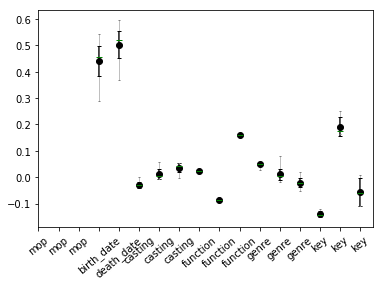

In [13]:
m, md, s = compute_playlist_stats(train_array[51], True)

Standard Deviation among all playlists

[0.03 0.01 0.02 0.07 0.07 0.02 0.02 0.02 0.   0.   0.   0.01 0.02 0.02
 0.06 0.07 0.08]
[0.00e+00 0.00e+00 0.00e+00 1.18e-02 1.01e-02 1.31e-03 4.96e-03 2.51e-03
 0.00e+00 7.45e-09 4.39e-08 4.74e-03 1.01e-02 6.16e-03 1.28e-02 3.61e-02
 1.96e-02]


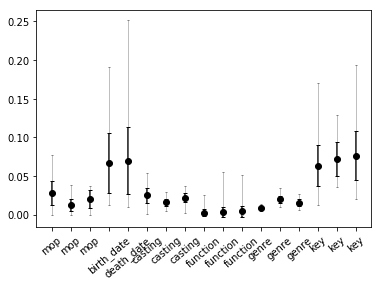

In [14]:
std = []
for pl in train_array:
    _mean, _median, _std = compute_playlist_stats(pl, False)
    std.append(_std)

mstd = np.ma.mean(std, axis=0)
sstd = np.ma.std(std, axis=0)
print(np.array(mstd))
smin = np.ma.min(std, axis=0)
smax = np.ma.max(std, axis=0)

print(np.array(smin))
plt.errorbar(np.arange(len(mstd)), mstd, sstd, fmt='ok',
             ecolor='black', elinewidth=1.5, lw=3, capsize=2)
plt.errorbar(np.arange(len(mstd)), mstd, [mstd - smin, smax - mstd],
         fmt='.k', ecolor='gray', elinewidth=0.5, lw=1, capsize=1)
plt.xticks(range(len(head_dim)), head_dim, rotation=40)
plt.show()


In [15]:
nstd = np.ma.array(std)
def print_stats_feat(feat):
    pos = np.where(np.array(head_dim) == feat)[0]
    _merged =  nstd[:,pos].mean(axis=1)
    _mean = _merged.mean()
    _median =  np.median(_merged)
    _min = _merged.min()
    _max = _merged.max()
    
    pmed = np.argsort(_merged)[len(_merged)//2]
    pmin = np.argmin(_merged)
    pmax = np.argmax(_merged)
    
    plt.bar(range(len(_merged)), np.ma.sort(_merged - _min) )
    
    ax1 = plt.axhline(y=_mean - _min, zorder=0, color='green', label='mean')
    ax2 = plt.axhline(y=_median - _min, zorder=0, color='blue', label='median')
    ax3 = plt.axhline(y= 0 , zorder=0, color='red', label='min')
    ax4 = plt.axhline(y= _max - _min, zorder=0, color='black', label='max')
    plt.legend(handles=[ax1, ax2, ax3, ax4])

    plt.show()
    
    print('Standard Deviation: \t mean \t\t median \t min \t\t max')
    print('\t\t\t %.2f%% \t\t %.2f%% \t\t %.2f%% \t\t %.2f%%' % ((100 * _mean),(100 * _median ), (100. * _min), (100. * _max)))
    print('\nMore omogeneous: playlist %s (%s)' % (pmin, train_names[pmin]))
    print('  |  '.join([get_label(u) for u in train_array[pmin]]))
    print('\nLess omogeneous: playlist %s (%s)' % (pmax, train_names[pmax]))
    print('  |  '.join([get_label(u) for u in train_array[pmax]]))

In [16]:
import warnings
warnings.filterwarnings('ignore')

## MoP

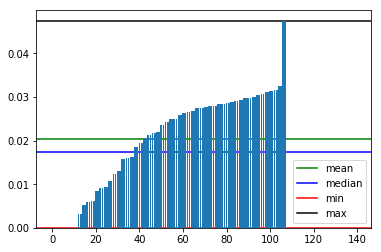

Standard Deviation: 	 mean 		 median 	 min 		 max
			 2.03% 		 1.74% 		 0.00% 		 4.75%

More omogeneous: playlist 10 (37i9dQZF1DWTZaA3VFnR5i.Classical World: UK & Ireland.artist.txt)
Peter Maxwell Davies  |  Henry Purcell  |  Benjamin Britten  |  William Walton  |  John Field  |  Edward Elgar  |  John Tavener  |  Ralph Vaughan Williams  |  Gustav Holst  |  John Dowland  |  Malcolm Arnold  |  Gerald Finzi  |  Christopher Tye  |  Frederick Delius  |  Harrison Birtwistle  |  Mark-Anthony Turnage  |  Thomas Tallis  |  Michael Tippett  |  William Byrd  |  Arnold Bax  |  Oliver Knussen  |  Judith Weir  |  George Benjamin  |  James MacMillan  |  Ernest John Moeran  |  Jonathan Dove  |  Arthur Sullivan  |  William Alwyn  |  John Ireland  |  Frank Bridge  |  Herbert Howells  |  Thomas Adès  |  Andrew Lloyd Webber  |  Karl Jenkins  |  John Dunstaple  |  John Taverner  |  Orlando Gibbons  |  Charles Villiers Stanford  |  Rebecca Clarke  |  Thomas Tomkins  |  Jonathan Harvey  |  Brian Ferneyhough 

In [17]:
print_stats_feat('mop')

## Period
Consider that:
- 0.001 (0.1%) =  1 year
- 0.01 (1%) = 10 years

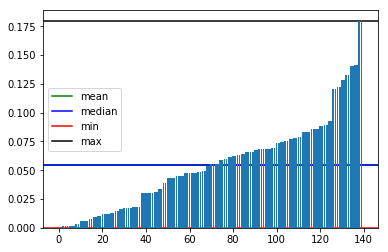

Standard Deviation: 	 mean 		 median 	 min 		 max
			 6.67% 		 6.64% 		 1.18% 		 19.16%

More omogeneous: playlist 56 (37i9dQZF1DX10uaP8FoDNe.Minimalism.artist.txt)
Philip Glass  |  Meredith Monk  |  William Duckworth  |  Arvo Pärt  |  Lubomyr Melnyk  |  Louis Andriessen  |  Daniel Bjarnason  |  Missy Mazzoli  |  Steve Reich  |  John Adams  |  Brian Eno  |  Gavin Bryars  |  Bryce Dessner  |  Frans Geysen  |  Paul Lansky  |  Tibor Szemzö  |  Ingram Marshall  |  Howard Skempton  |  Karel Goeyvaerts  |  Robert Moran  |  Stephen Scott  |  Julius Eastman  |  Evan Ziporyn  |  Simon Rackham  |  Janice Giteck  |  John Tavener  |  Arvo Pärt  |  Paul Dresher  |  Michael Nyman

Less omogeneous: playlist 44 (37i9dQZF1DWYiS8hkmdLyc.Classical World: Belgium & The Netherlands.artist.txt)
César Franck  |  Johannes Ockeghem  |  Eugène Ysaÿe  |  Roland de Lassus  |  Henri Vieuxtemps  |  Jan Pieterszoon Sweelinck  |  Willem Pijper  |  Unico Wilhelm van Wassenaer  |  Hendrik Andriessen  |  Louis Andriesse

In [18]:
print_stats_feat(['birth_date'])

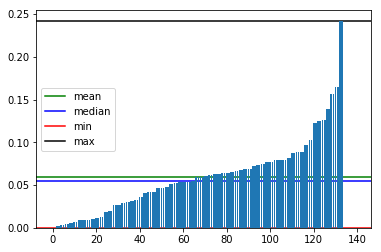

Standard Deviation: 	 mean 		 median 	 min 		 max
			 6.96% 		 6.45% 		 1.01% 		 25.23%

More omogeneous: playlist 56 (37i9dQZF1DX10uaP8FoDNe.Minimalism.artist.txt)
Philip Glass  |  Meredith Monk  |  William Duckworth  |  Arvo Pärt  |  Lubomyr Melnyk  |  Louis Andriessen  |  Daniel Bjarnason  |  Missy Mazzoli  |  Steve Reich  |  John Adams  |  Brian Eno  |  Gavin Bryars  |  Bryce Dessner  |  Frans Geysen  |  Paul Lansky  |  Tibor Szemzö  |  Ingram Marshall  |  Howard Skempton  |  Karel Goeyvaerts  |  Robert Moran  |  Stephen Scott  |  Julius Eastman  |  Evan Ziporyn  |  Simon Rackham  |  Janice Giteck  |  John Tavener  |  Arvo Pärt  |  Paul Dresher  |  Michael Nyman

Less omogeneous: playlist 70 (37i9dQZF1DX561TxkFttR4.88 Keys.artist.txt)
Max Richter  |  Ólafur Arnalds  |  Nils Frahm  |  Guido  |  Ólafur Arnalds  |  Yann Tiersen  |  Ólafur Arnalds  |  Ludovico Einaudi  |  Nils Frahm  |  Chilly Gonzales  |  Nils Frahm  |  Aphex Twin  |  Max Richter  |  Chilly Gonzales  |  Ólafur Arnalds

In [19]:
print_stats_feat(['death_date'])

Less omogeneous: "88 keys" https://open.spotify.com/user/spotify/playlist/37i9dQZF1DX561TxkFttR4
Unfortunately we have not all the keys for this artists/expression (just for Rameau), so this not appears in the key section

## Casting

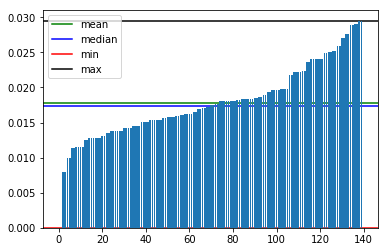

Standard Deviation: 	 mean 		 median 	 min 		 max
			 2.07% 		 2.03% 		 0.29% 		 3.24%

More omogeneous: playlist 40 (37i9dQZF1DWYZW76Iw4Lij.Medieval 50: Spotify Picks.artist.txt)
Pérotin  |  Léonin  |  Jacopo da Bologna  |  Baude Cordier  |  Oswald von Wolkenstein  |  Lorenzo da Firenze  |  Francesco Landini  |  Gherardello da Firenze  |  Alfonso X El Sabio  |  Johannes Ciconia  |  Francesco Landini  |  Guillaume de Machaut  |  Philippe de Vitry  |  Johannes Ciconia  |  Bartolino da Padova  |  Oswald von Wolkenstein  |  Matteo da Perugia  |  Lorenzo da Firenze  |  Guillaume de Machaut  |  Wolfram von Eschenbach  |  Jaquemin de Senleches  |  Petrus de Cruce  |  Adam de Saint-Victor  |  Walther von der Vogelweide  |  Neidhart von Reuental  |  Lorenzo da Firenze  |  Trebor  |  Gacian Reyneau  |  John Dunstaple  |  Jaquemin de Senleches  |  Antonius Romanus  |  Arnold de Lantins  |  Leonel Power

Less omogeneous: playlist 70 (37i9dQZF1DX561TxkFttR4.88 Keys.artist.txt)
Max Richter  |  Ólaf

In [26]:
print_stats_feat('casting')

## Function

This dimension can be misleading, because we are selecting artist that are composer of songs.

In particular the minimum is when all the artist are **only** composers

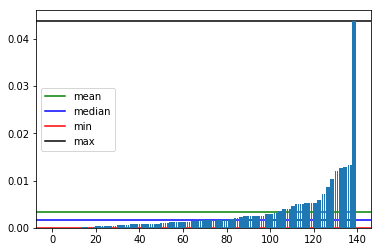

Standard Deviation: 	 mean 		 median 	 min 		 max
			 0.33% 		 0.16% 		 0.00% 		 4.38%

More omogeneous: playlist 76 (37i9dQZF1DX6Cc1xytKlor.Classical World: Argentina.artist.txt)
Carlos Guastavino  |  Astor Piazzolla  |  Julián Aguirre  |  Ariel Ramirez  |  Máximo Diego Pujol  |  Alberto Ginastera  |  Juan José Castro  |  Osvaldo Golijov  |  Alberto Williams  |  Lalo Schifrin  |  Carlos Gardel  |  Jorge Morel  |  Mariano Mores  |  Carlos Lopez-Buchardo  |  Juan de Dios Filiberto  |  Esteban Benzecry  |  Carlos Grätzer  |  Martin Matalon  |  Mauricio Kagel

Less omogeneous: playlist 96 (37i9dQZF1DX7dzHXrANAir.Classical X.artist.txt)
Nils Frahm  |  Catherine Lara  |  Francesco Tristano  |  Simeon ten Holt  |  Morton Feldman  |  Max Richter  |  Missy Mazzoli  |  Ryuichi Sakamoto  |  Michael Gordon  |  L. T. Lambert  |  David Lang  |  Ólafur Arnalds  |  Terry Riley  |  Brian Eno  |  John Luther Adams  |  Nico Muhly  |  Ludovico Einaudi  |  Arvo Pärt  |  Steve Reich  |  Ken Thomson  |  Jan

In [27]:
print_stats_feat('function')

## Genre

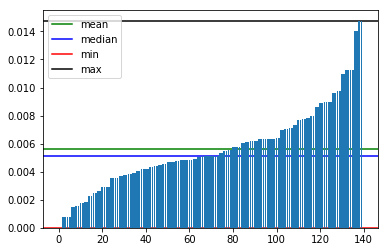

Standard Deviation: 	 mean 		 median 	 min 		 max
			 1.43% 		 1.38% 		 0.87% 		 2.35%

More omogeneous: playlist 104 (37i9dQZF1DX9CrmarDZuOr.Classical World: Sweden.artist.txt)
Wilhelm Peterson-Berger  |  Hugo Alfvén  |  Wilhelm Stenhammar  |  Nils Lindberg  |  Kurt Atterberg  |  Johan Helmich Roman  |  Lars Erik Larsson  |  Franz Berwald  |  Anders Hillborg  |  Karl-Birger Blomdahl  |  Ture Rangström  |  Anders Eliasson  |  Hilding Rosenberg  |  Erland von Koch  |  Lille Bror Söderlundh  |  Carl Michael Bellman  |  Karin Rehnqvist  |  Dag Wirén  |  Gösta Nystroem  |  Jan Sandström  |  Joseph Martin Kraus  |  Sven-David Sandström  |  Bo Nilsson  |  Ingvar Lidholm  |  Rolf Martinsson

Less omogeneous: playlist 66 (37i9dQZF1DX43qoHiOOgIz.Classical World: Mexico.artist.txt)
Manuel María Ponce  |  José Pablo Moncayo  |  Arturo Márquez  |  José Rolón  |  Juventino Rosas  |  Agustin Lara  |  Carlos Chávez  |  Javier Alvarez  |  Silvestre Revueltas  |  Hernando Franco  |  Gaspar Fernandes  |

In [22]:
print_stats_feat('genre')

## Key

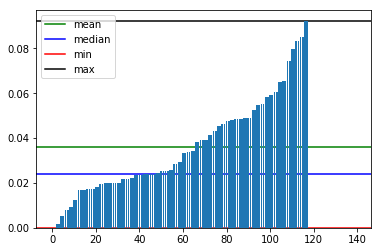

Standard Deviation: 	 mean 		 median 	 min 		 max
			 7.06% 		 5.85% 		 3.44% 		 12.67%

More omogeneous: playlist 50 (37i9dQZF1DX0CM2xT3aAkN.Essence of the Renaissance.artist.txt)
Matthew Locke  |  Thomas Tallis  |  Heinrich Isaac  |  Carlo Gesualdo  |  Claudio Monteverdi  |  Thomas Weelkes  |  Luca Marenzio  |  Christopher Tye  |  Giovanni Pierluigi da Palestrina  |  Orlando Gibbons  |  William Byrd  |  Tomás Luis de Victoria  |  Philippe de Monte  |  Antoine Brumel  |  Alessandro Striggio  |  Michael Praetorius  |  Guillaume Dufay  |  Clément Janequin  |  Paschal de L'Estocart  |  Alexander Agricola  |  Antoine Busnois  |  Guillaume Dufay  |  Michael Praetorius  |  Antoine Brumel  |  Carlo Gesualdo  |  John Dowland  |  Johannes Ockeghem  |  Roland de Lassus  |  Josquin Des Prés  |  Francisco de Peñalosa  |  Johannes Ockeghem  |  Roland de Lassus  |  Giovanni Gabrieli  |  Jan Pieterszoon Sweelinck  |  Nicolas Gombert  |  Giovanni Pierluigi da Palestrina  |  Jan Pieterszoon Sweelinck 

In [23]:
print_stats_feat('key')

In [24]:
# minibatches_len = 8

In [ ]:
# training_vector_all = []
# for t in train_array:
#     if(len(t) < minibatches_len):
#         continue
    
#     training_vector_all.append(np.array([get_embs(xi) for xi in t]))